# Clockwork Axion

In [9]:
%run observables.py
%run clockwork_axion.py
%run plot_tools.py
%run util.py
%run analysis_tools.py

## $m_\phi$ vs $mR$ parameterspace from Paper

In [10]:
v = 2
data = load_data("clockwork_mR_vs_mphi", v)

In [13]:
data["Omega_h_sq"].shape

(1, 3, 50, 51)

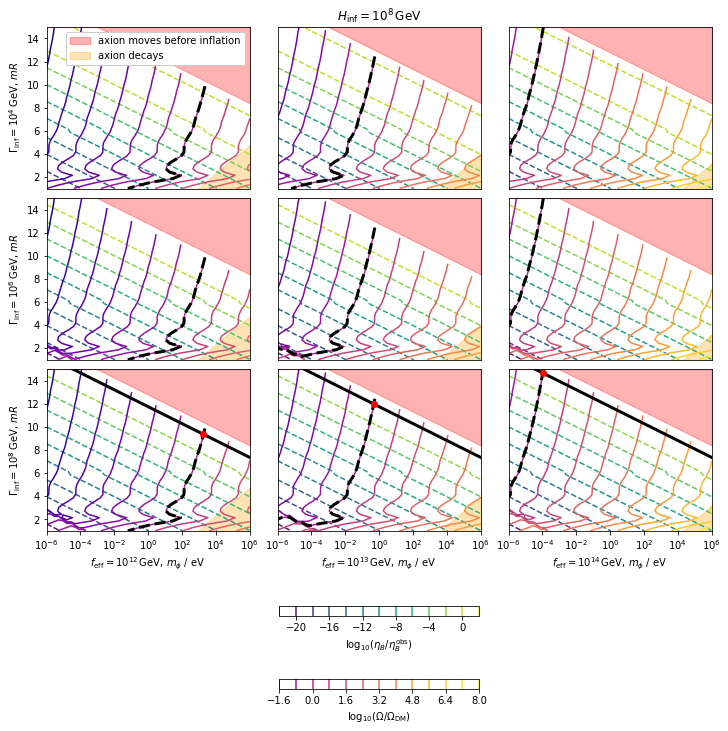

In [45]:
m_phi = data["m_phi"]
mR = data["mR"]
H_inf = data["H_inf"][0]
f_effs = [1e12, 1e13, 1e14]
Gamma_infs = data["Gamma_inf"]
max_mR = np.array([compute_max_mR(x, H_inf, 3*np.pi/4) for x in m_phi])

fig, axs = plt.subplots(len(Gamma_infs), len(f_effs), figsize=(10, 10), constrained_layout=True)
#fig.subplots_adjust(wspace=0, hspace=0)

def recompute_relic_density(old_Omega_h_sq, new_f_eff):
    eps = calc_eps(mR)
    old_f = calc_f(default_f_eff, eps)
    new_f = calc_f(new_f_eff, eps)
    new_Omega_h_sq = old_Omega_h_sq / old_f[:, None]**2 * new_f[:, None]**2
    return new_Omega_h_sq

Bs = [[np.log10(recompute_relic_density(data["Omega_h_sq"][0, Gamma_inf_index, ...], f_eff) / Omega_DM_h_sq) 
    for f_eff in f_effs] for Gamma_inf_index in range(len(Gamma_infs))]
vmin_B = min(np.nanmin(B) for row in Bs for B in row)
vmax_B = max(np.nanmax(B) for row in Bs for B in row)

for i, Gamma_inf in enumerate(Gamma_infs):
    A = np.log10(data["eta"][0, i, ...] / eta_B_observed)
    
    for j, f_eff in enumerate(f_effs):
        min_mR = np.array([compute_min_mR(x, f_eff) for x in m_phi])
        Omega_level = list(find_level(np.log10(m_phi * 1e9), mR, Bs[i][j]))
        eta_level = list(find_level(np.log10(m_phi * 1e9), mR, A))

        axs[i, j].set_xscale("log")

        contour1 = axs[i, j].contour(m_phi * 1e9, mR, A, levels=10, cmap="viridis", linestyles="--")
        contour2 = axs[i, j].contour(m_phi * 1e9, mR, Bs[i][j], levels=10, cmap="plasma", linestyles="-", vmin=vmin_B, vmax=vmax_B)

        for xs, ys in eta_level:
            axs[i, j].plot(10**xs, ys, "k", lw=3)
        for xs, ys in Omega_level:
            axs[i, j].plot(10**xs, ys, "--k", lw=3)

        if len(eta_level) > 0 and len(Omega_level) > 0:
            x, y = find_curve_intersection(*eta_level[0], *Omega_level[0])
            axs[i, j].plot([10**x], [y], "ro")

        axs[i, j].fill_between(m_phi * 1e9, max_mR, mR[-1], alpha=0.3, color="red", label="axion moves before inflation")
        axs[i, j].fill_between(m_phi * 1e9, min_mR, mR[0] , alpha=0.3, color="orange", label="axion decays")
        if (i, j) == (0, 0):
            axs[i, j].legend(framealpha=1)
        axs[i, j].set_ylim(mR[0], mR[-1])

        if j != 0:
            axs[i, j].set_yticks([], [])
        else:
            axs[i, j].set_ylabel(r"$\Gamma_\mathrm{inf} = " + latex_exponential_notation(Gamma_inf, 2) + r"\, \mathrm{GeV}$, $mR$")                   
        if i != len(Gamma_infs) - 1:
            axs[i, j].set_xticks([], [])
        else:
            axs[i, j].set_xlabel(r"$f_\mathrm{eff} = " + latex_exponential_notation(f_eff, 2) + r"\, \mathrm{GeV}$, $m_\phi$ / eV")
            
        if i == 0 and j == 1:
            axs[i,j].set_title(f"$H_\\mathrm{{inf}} = {latex_exponential_notation(H_inf, 2)} \\, \\mathrm{{GeV}}$")
        
cbar2 = fig.colorbar(contour2, ax=axs, label=r"$\log_{10}(\Omega / \Omega_\mathrm{DM})$", shrink=0.3, location="bottom")
cbar1 = fig.colorbar(contour1, ax=axs, label=r"$\log_{10}(\eta_B / \eta^\mathrm{obs}_B)$", shrink=0.3, location="bottom") 

fig.savefig("plot.pdf")

## $m_\phi$ vs $\Gamma_\mathrm{inf}$ parameterspace

In [11]:
def plot_run(n, show_status=False):
    data = load_data("clockwork_Gammainf_vs_mphi", n)

    for i in range(len(data["mR"])):
        eta_B = data["eta"][0, :, i, :]
        Omega_h_sq = data["Omega_h_sq"][0, :, i, :]
        m_phi = data["m_phi"]
        Gamma_inf = data["Gamma_inf"]
        mR = data["mR"][i]
        H_inf = data["H_inf"][0]

        plt.figure()
        A = np.log10(eta_B / eta_B_observed)
        contour1 = plt.contour(m_phi * 1e9, Gamma_inf, A, 
                               levels=10, cmap="viridis", linestyles="-")
        
        for xs, ys in find_level(np.log10(m_phi * 1e9), np.log10(Gamma_inf), A):
            plt.plot(10**xs, 10**ys, "r", lw=3)
        
        cbar1 = plt.colorbar()
        cbar1.set_label(r"$\log_{10}(\eta_B / \eta^\mathrm{obs}_B)$")
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel(r"$m_\phi$ / eV")
        plt.ylabel(r"$\Gamma_\phi$ / GeV")
        plt.title(f"$H_\\mathrm{{inf}} = {latex_exponential_notation(H_inf, 2)} \\, \\mathrm{{GeV}}, \\, mR = {mR}$")
        
        if show_status:
            plt.figure()
            plt.pcolormesh(data["status"][0, :, i, :])
            plt.colorbar()
            plt.title("return status")

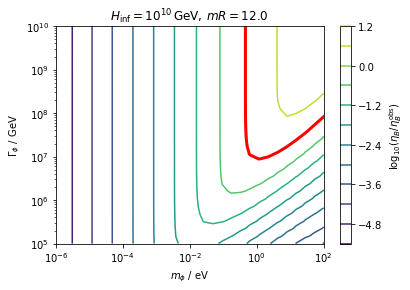

In [12]:
plot_run(5)

## Find Correct Points in Parameterspace

## other stuff

Text(0, 0.5, 'mR')

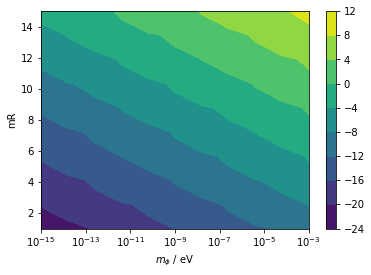

In [16]:
curvature = np.array([[calc_d2V_eff_dphi2(theta_to_phi_over_f(1.0, calc_eps(mR)), calc_eps(mR), m_phi / calc_eps(mR))
            for m_phi in m_phi_range] for mR in mR_range])
plt.contourf(m_phi_range * 1e9, mR_range, np.log10(np.sqrt(curvature) / H_inf) )
plt.xscale("log")
plt.colorbar()
plt.xlabel(r"$m_\phi$ / eV")
plt.ylabel(r"mR")

Text(0.5, 0, 'mR')

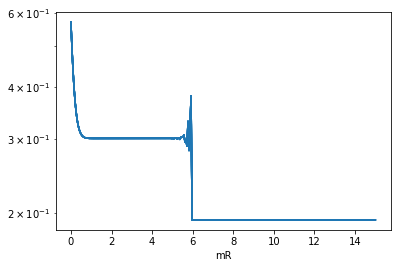

In [29]:
for m_phi in m_phi_range:
    mRs = np.linspace(0, 15, 300)
    A = np.array([calc_d2V_eff_dphi2(theta_to_phi_over_f(1.0, calc_eps(mR)), calc_eps(mR), m_phi / calc_eps(mR))
                   / (m_phi / calc_eps(mR))**2 for mR in mRs])
    plt.plot(mRs, A, color="tab:blue")
plt.yscale("log")
plt.xlabel(r"mR")

## Plot of the effective Potential

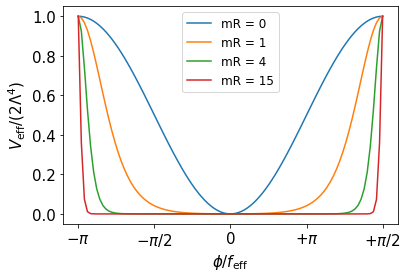

In [5]:
Gamma_phi = 1e7
H_inf = 2e10
mR = 6
m_phi = 100 * 1e-9 # [GeV]
eps = calc_eps(mR)
f = 1e12
f_eff = calc_f_eff(f, eps)
M = m_phi / eps 
alpha_range = np.linspace(-np.pi, np.pi, 100)
for plot_mR in [0, 1, 4, 15]:
    eps = calc_eps(plot_mR)
    phi_over_f_range = calc_f_eff(f, eps) * alpha_range / f # not a linear map
    Lambda = np.sqrt(M * f)
    y = calc_V_eff_over_f_sq(phi_over_f_range, eps, M) * f**2 / (2*Lambda**4)
    y[0] = 1; y[-1] = 1 # okay this is bad
    plt.plot(alpha_range, y, label=f"mR = {plot_mR}")
plt.xlabel(r"$\phi / f_\mathrm{eff}$")
plt.ylabel(r"$V_\mathrm{eff} / (2 \Lambda^4)$")
plt.legend()
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r"$-\pi$", r"$-\pi/2$", "0", r"$+\pi/2$", r"$+\pi$",])
plt.yticks();

## Example Evolution

step = 1
calculcated initial integration time:
tmax_inf_time = 36.93551012003315 tmax_axion_time = 3.6935510120033156e-14
rh: 0.24242711067199707
axion: 0.006184577941894531
transport eq.: 0.23056912422180176
B-L range: -5.394523789005145e-41 0.0
delta = 4.089465179349102 rtol_asym = 0.001
step = 2
rh: 0.1023566722869873
axion: 0.34272003173828125
transport eq.: 1.3460006713867188
B-L range: -2.3654746879464492e-21 -5.394523789005141e-41
delta = 14.301657259633428 rtol_asym = 0.001
step = 3
rh: 0.00011134147644042969
axion: 0.08912229537963867
transport eq.: 1.3012051582336426
B-L range: -2.2217315003778924e-21 -2.182178982916872e-21
delta = 0.01797431261471428 rtol_asym = 0.001
step = 4
rh: 0.00010752677917480469
axion: 0.07976603507995605
transport eq.: 1.572765588760376
B-L range: -2.2119506364728324e-21 -2.1981934675046165e-21
delta = 0.006241746594461395 rtol_asym = 0.001
step = 5
rh: 0.00012922286987304688
axion: 0.09020018577575684
transport eq.: 1.7463457584381104
B-L range: -2

(1.922333779004356e-23, 1.0, 3.24521989323041, 1.0)

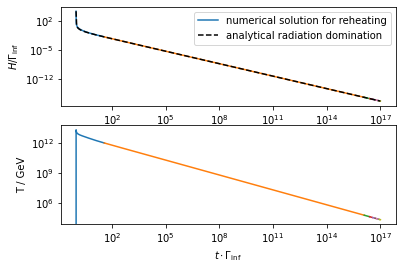

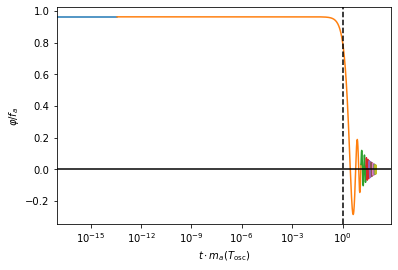

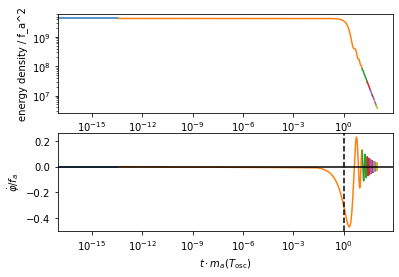

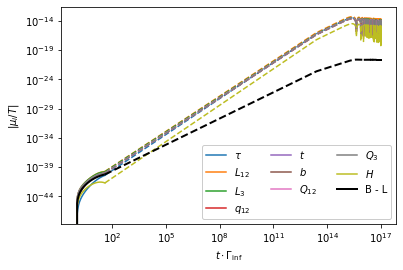

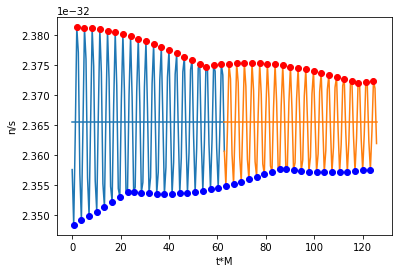

In [1]:
%run observables.py
%run clockwork_axion.py
H_inf = 2e12
Gamma_inf = 1e8
mR = 0
m_phi = 100 * 1e-9 # [GeV]
eps = calc_eps(mR)
f = 1e12
f_eff = calc_f_eff(f, eps)
M = m_phi / eps 
compute_observables(H_inf, Gamma_inf, (eps, M), f, clockwork_axion_field, (theta_to_phi_over_f(1.0, eps), 0.0), 
                    calc_init_time=True, debug=True)

In [ ]:
t0, initial = reheating.calc_initial_reheating(H_inf)
tf_2 = cosmology.switch_hubble_and_time_rad_dom(m_phi) * 1e3
T_fn, H_fn, _, final = reheating.solve_reheating_eq(t0, tf_2, initial, Gamma_phi)
sol = clock_work_axion.evolve(t0, tf_2, (clock_work_axion.theta_to_phi_over_f(1, eps), 0), (eps, M, H_fn))
plt.semilogx(sol.t, sol.y[0], lw=2)
plt.xlabel(r"$t \cdot \mathrm{GeV}$", fontsize=15)
plt.ylabel(r"$\phi / f$ ", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);
plt.annotate("Slow Roll", (1e-6, 37), (1e-6, 30), arrowprops=dict(arrowstyle="->"), fontsize=15)
plt.annotate("Fast Roll", (5e0, 33), (1e3, 32), arrowprops=dict(arrowstyle="->"), fontsize=15)
plt.annotate("Tracking", (0.5e4, 17), (1e6, 20), arrowprops=dict(arrowstyle="->"), fontsize=15)
plt.annotate("Oscillations", (1e-4, 21), (1e-5, 25), arrowprops=dict(arrowstyle="->"), fontsize=15)
ax = plt.gca()
i = np.where(sol.y[0] < 0)[0][0]
inset_ax = ax.inset_axes([0.15, 0.15, 0.4, 0.4])
inset_ax.semilogx(sol.t[i:], sol.y[0, i:])
ax.indicate_inset_zoom(inset_ax, edgecolor="black");